In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from agents import *
from environments import RaceTrack
from multiproc_utils import TrainPool

from IPython.display import Image

from itertools import product

In [2]:
track = RaceTrack(RaceTrack.track_impossible)
track.set_eval()

initial_alpha = 0.5
initial_epsilon = 0.1

n = 4
alphas = [0.0]
epsilons = [0.0]
selectors = [EpsilonGreedy(epsilon=0.05)]
scheduless = [
    [
        SigmoidSchedule(["learner", "alpha"], initial_alpha, alpha),
        SigmoidSchedule(["selector", "epsilon"], initial_epsilon, epsilon),
    ] for alpha, epsilon in product(alphas, epsilons)
]
learners = [
    NStepExpectedSarsa(n=n, alpha=initial_alpha),
    NStepTreeBackup(n=n, alpha=initial_alpha),
]

In [3]:
agents = Agent.combinations(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selectors=selectors,
    learners=learners,
    scheduless=scheduless,
    planners=[None],
)

In [4]:
num_episodes = 100
num_runs = 3

pool = TrainPool(agents, track, quiet=num_runs > 1)
agents = pool.train_average(num_episodes, num_runs)

Training Runs:   0%|          | 0/3 [00:00<?, ?it/s]

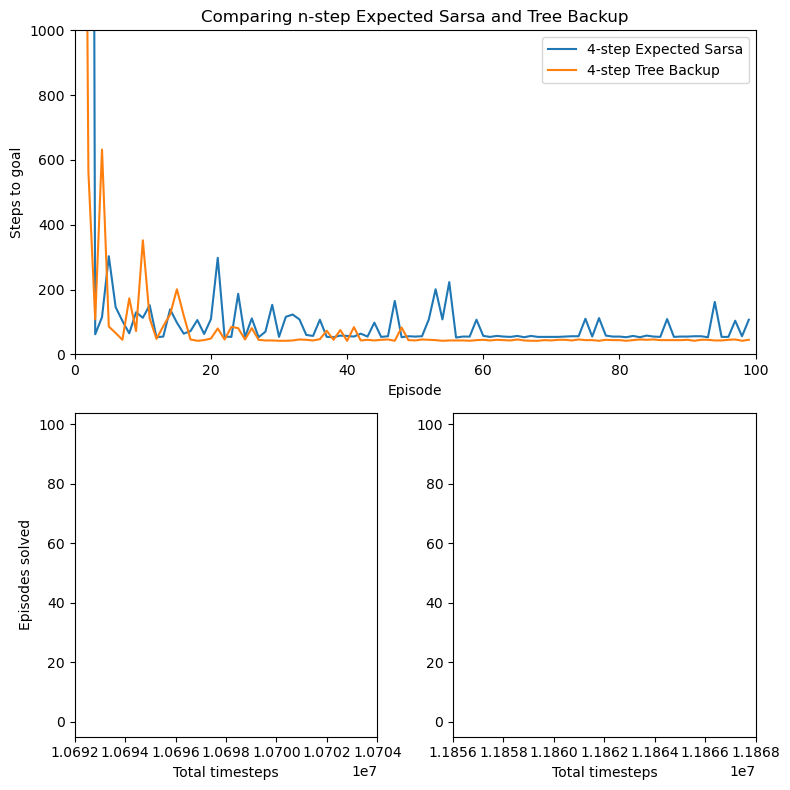

In [5]:
trail_length = 1
start_from = 0
end_at = num_episodes

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(2, 1, 1)

names = [f"{n}-step Expected Sarsa", f"{n}-step Tree Backup"]
for agent, name in zip(agents, names):
    xs, ys = agent.smoothed_ep_lengths(trail_length)
    ax1.plot(xs[start_from:end_at], ys[start_from:end_at], label=name)

ax1.set_title("Comparing n-step Expected Sarsa and Tree Backup")
ax1.legend()
ax1.set_xlabel("Episode")
ax1.set_ylabel("Steps to goal")

ax1.set_xlim(0, 100)
ax1.set_ylim(0, 1_000)

ax2a = fig.add_subplot(2, 2, 3) 
ax2b = fig.add_subplot(2, 2, 4, sharey=ax2a)

for agent, name in zip(agents, names):
    xs, ys = agent.cumulative_eps()
    ax2a.plot(xs[start_from:end_at], ys[start_from:end_at], label=name)
    ax2b.plot(xs[start_from:end_at], ys[start_from:end_at], label=name)

ax2a.set_xlabel("Total timesteps")
ax2a.set_ylabel("Episodes solved")

ax2b.set_xlabel("Total timesteps")

ax2a.set_xlim(1.0692e7, 1.0704e7)
ax2b.set_xlim(1.1856e7, 1.1868e7)

plt.tight_layout()
plt.show()

In [12]:
agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=EpsilonGreedy(0.1),
    learner=NStepTreeBackup(1, 0.5),
    schedules=[
        LinearSchedule(
            ["learner", "alpha"],
            0.5,
            0.0,
        ),
        SigmoidSchedule(
            ["selector", "epsilon"],
            0.1,
            0.0,
        )
    ]
)
trainer = Trainer(agent, track)

In [ ]:
trainer.train(40, early_stop=1)
agent.learner = NStepTreeBackup(2, 0.5)
trainer.train(40, early_stop=2)
agent.learner = NStepTreeBackup(3, 0.5)
trainer.train(40, early_stop=3)
agent.learner = NStepTreeBackup(4, 0.5)
trainer.train(40, early_stop=4)
agent.learner = NStepTreeBackup(5, 0.5)
trainer.train(40, early_stop=5)
agent.learner = NStepTreeBackup(6, 0.5)
trainer.train(40, early_stop=6)
agent.learner = NStepTreeBackup(7, 0.5)
trainer.train(40)

Episodes:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
track.set_eval()
episode, _, _ = agent.play_episode(track, 100)
print("Episode finished! Rendering animation...")
track.set_train()

ep_name = "Playground Testing"
filename = track.render_episode(episode, ep_name=ep_name)
Image(filename)